<a href="https://colab.research.google.com/github/Jvlia17/deep-learning/blob/main/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Projekt ten ma na celu przeprowadzenie ataku aderwsarzowego metodą FGSM na głęboką sieć neuronową o architekturze typu ResNet (*Residual neural network*). W projekcie sprawdzony zostanie wpływ parametru ɛ metody FGSM. W celu przeprowadzenia eksperymentów, zostanie wytrenowana sieć ResNet na zbiorze CIFAR-10. Zostanie sprawdzona metoda obrony przed takimi atakami, tj. dodanie rozmycia do obrazu wejściowego.

Na początku zatem należy stworzyć model. Architektura modelu została zaimplementowana na podstawie [[1]](https://arxiv.org/pdf/1512.03385.pdf) oraz [[2]](https://github.com/akamaster/pytorch_resnet_cifar10). Zaimplementowano model o 110 warstwach, ResNet110, jako że jak podaje [[1]](https://arxiv.org/pdf/1512.03385.pdf), otrzymano na nim najmniejszy błąd dla zbioru CIFAR10.

https://github.com/akamaster/pytorch_resnet_cifar10

https://arxiv.org/pdf/1512.03385.pdf

https://medium.com/analytics-vidhya/resnet-10f4ef1b9d4c

https://pytorch-tutorial.readthedocs.io/en/latest/tutorial/chapter03_intermediate/3_2_2_cnn_resnet_cifar10/

https://towardsdatascience.com/resnets-for-cifar-10-e63e900524e0

https://www.kaggle.com/code/banerz/resnet-implementation-in-pytorch

https://blog.paperspace.com/writing-resnet-from-scratch-in-pytorch/



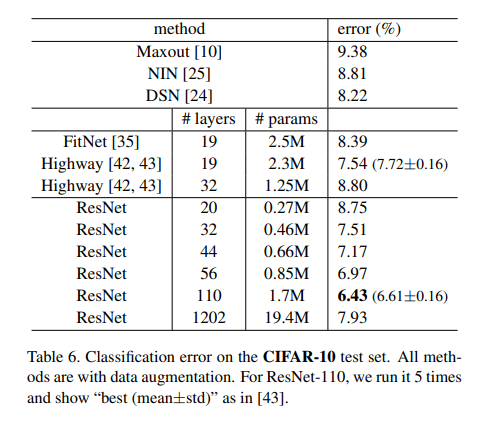

*We follow the simple data augmentation in [24] for training: 4 pixels are padded on each side,
and a 32×32 crop is randomly sampled from the padded
image or its horizontal flip. For testing, we only evaluate
the single view of the original 32×32 image.*

In [ ]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4133 sha256=b9fb8fe21d8cc3d289e1404566100cfded5095a0b5bf8631a087f4a9a209b437
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [ ]:
# !pip install neptune

In [ ]:
# import neptune
# from getpass import getpass

# api_token = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI4MDQ0MzA5Yi1jNmU5LTRlNjMtODg5YS1lYjdjOTU3Yzc0MDMifQ=="
# project="mgraves236/deep-learning"
# project = neptune.init_project(project=project, api_token=api_token)
# print(project)

# run = neptune.init_run(
#     project="mgraves236/deep-learning",
#     api_token=api_token,
#     capture_hardware_metrics=True,
#     capture_stderr=True,
#     capture_stdout=True,
# )

https://app.neptune.ai/mgraves236/deep-learning/
https://app.neptune.ai/mgraves236/deep-learning/e/DEEP-10


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
# from torchviz import make_dot
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as utils
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super().__init__()
        self.inplanes = 16
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 16, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(16),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 16, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 32, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 64, layers[2], stride = 2)
        self.fc = nn.Linear(64, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)


    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = F.avg_pool2d(x, x.size()[3])
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

model = ResNet(ResidualBlock, [18,18,18]).to(device)

summary(model, (3, 32, 32))

# x = torch.randn(1,3,32, 32)
# y = model(x)

# make_dot(y.mean(), params=dict(model.named_parameters())).render("rnn_torchviz", format="png")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
         MaxPool2d-4           [-1, 16, 16, 16]               0
            Conv2d-5           [-1, 16, 16, 16]           2,320
       BatchNorm2d-6           [-1, 16, 16, 16]              32
              ReLU-7           [-1, 16, 16, 16]               0
            Conv2d-8           [-1, 16, 16, 16]           2,320
       BatchNorm2d-9           [-1, 16, 16, 16]              32
             ReLU-10           [-1, 16, 16, 16]               0
    ResidualBlock-11           [-1, 16, 16, 16]               0
           Conv2d-12           [-1, 16, 16, 16]           2,320
      BatchNorm2d-13           [-1, 16, 16, 16]              32
             ReLU-14           [-1, 16,

Wczytanie zbioru danych:

In [ ]:
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
classes = trainset.classes
print(classes)

100%|██████████| 170498071/170498071 [00:05<00:00, 30644382.46it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
# calculate mean and std for the dataset
imgs_train = torch.stack([img_t for img_t ,_ in trainset],dim=3)
imgs_test = torch.stack([img_t for img_t ,_ in testset],dim=3)
imgs = torch.cat((imgs_train, imgs_test), 3)
mean = imgs.view(3,-1).mean(dim=1).numpy()
std = imgs.view(3, -1).std(dim=1).numpy()
print(mean, std)

normalize= transforms.Normalize(mean=[mean[0], mean[1], mean[2]],
                                     std=[std[0], std[1], std[2]])

[0.49186882 0.48265398 0.44717732] [0.24697122 0.24338895 0.2615926 ]


In [ ]:
# data augmentation: 4 pixels are padded on each side,
# and a 32×32 crop is randomly sampled from the padded
# image or its horizontal flip

normalize= transforms.Normalize(mean=[0.49186882, 0.48265398, 0.44717732], std=[0.24697122, 0.24338895, 0.2615926 ])
batch_size = 128

train_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root='./data', train=True, transform=transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,
        ]), download=True),
        batch_size=batch_size, shuffle=True, pin_memory=True)

test_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ]), download=True),
        batch_size=batch_size, shuffle=True, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


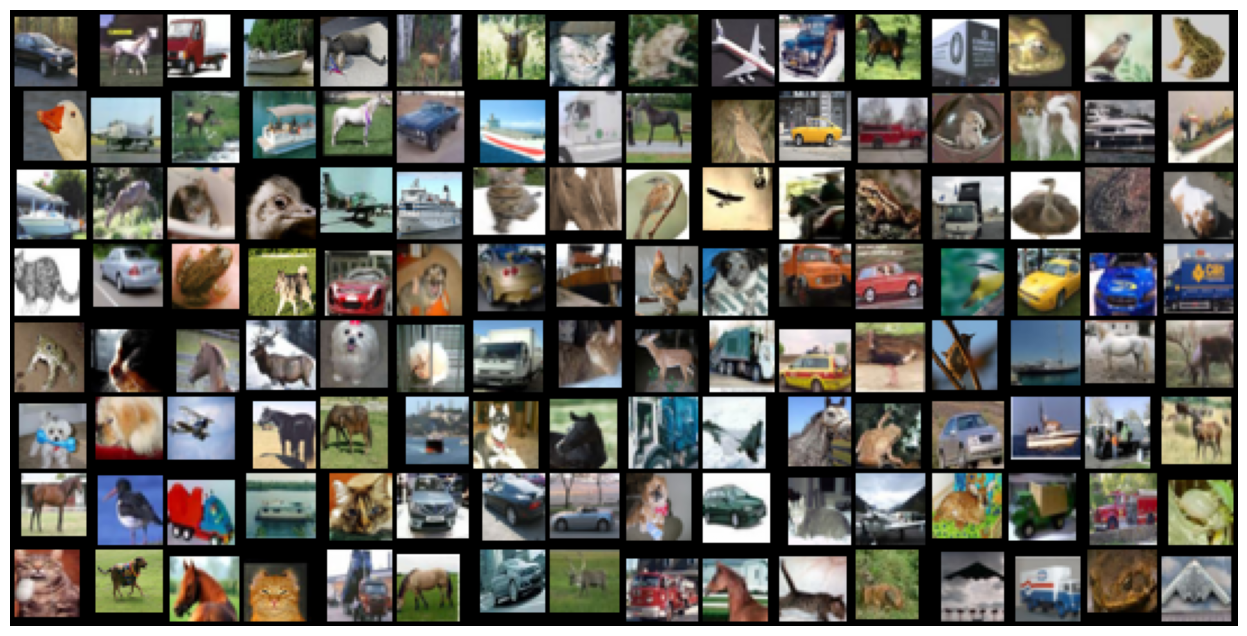

In [ ]:
for images, _ in train_loader:
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(utils.make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [ ]:
# Hyper-parameters
num_epochs = 200
learning_rate = 0.001
weight_decay = 0.0001
momentum = 0.9

# params = {"epochs": num_epochs,
#           "learning_rate": learning_rate,
#           "weight_decay": weight_decay,
#           "momentum": momentum}

# run["parameters"] = params

In [ ]:
# Training the model
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torchsummary import summary
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum)
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=learning_rate, max_lr=0.1,step_size_up=100,mode="exp_range",gamma=0.85)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150])
#0.1



for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    data_loader = tqdm(train_loader, total=len(train_loader), desc=f'Epoch [{epoch + 1}/{num_epochs}]')

    for batch_idx, (inputs, targets) in enumerate(data_loader):
        optimizer.zero_grad()
        inputs, targets = inputs.to(device), targets.to(device)


        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = outputs.max(1)
        correct_predictions += predicted.eq(targets).sum().item()
        total_samples += targets.size(0)

        # Progress bar description
        data_loader.set_postfix(loss=total_loss / (batch_idx + 1), accuracy=correct_predictions / total_samples)

    average_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_samples

    # test the model
    correct_test, total_test, total_loss_test = 0, 0, 0
    with torch.no_grad():
      for (inputs, targets) in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        total_loss_test += loss.item()

        __, predicted = outputs.max(1)
        correct_test += predicted.eq(targets).sum().item()
        total_test+= targets.size(0)

      accuracy_test = correct_test / total_test
      average_loss_test = total_loss_test / len(test_loader)

    print(f'Epoch [{epoch + 1}/{num_epochs}] - Loss: {average_loss:.4f}, Accuracy: {accuracy * 100:.2f}%, Loss on test data: {average_loss_test:.4f} Accuracy on test data: {100 * accuracy_test:.2f} %')
    # run["train/accuracy"].append(accuracy)
    # run["train/avg_loss"].append(average_loss)
    # run["test/accuracy"].append(accuracy_test)
    # run["test/avg_loss"].append(average_loss_test)
    # run["train/learning_rate"].append(optimizer.param_groups[0]["lr"])
    model_save_path = '/content/drive/MyDrive/DL/multistep/109-/resnet_cifar10_' + str(epoch+1) + '.pth'
    training_stats = {
      'epoch': epoch+1,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'scheduler_state_dict': scheduler.state_dict(),
      'loss': average_loss,
      'accuracy': accuracy,
      'test_accuracy': accuracy_test,
      'test_loss': average_loss_test,
      'learning_rate': optimizer.param_groups[0]["lr"]
    }
    scheduler.step()
    torch.save(training_stats, model_save_path)

Epoch [1/200]: 100%|██████████| 391/391 [00:49<00:00,  7.96it/s, accuracy=0.258, loss=1.98]


Epoch [1/200] - Loss: 1.9819, Accuracy: 25.83%, Loss on test data: 1.7264 Accuracy on test data: 35.39 %


Epoch [2/200]: 100%|██████████| 391/391 [00:49<00:00,  7.94it/s, accuracy=0.38, loss=1.67]


Epoch [2/200] - Loss: 1.6660, Accuracy: 37.96%, Loss on test data: 1.5389 Accuracy on test data: 43.31 %


Epoch [3/200]: 100%|██████████| 391/391 [00:49<00:00,  7.86it/s, accuracy=0.435, loss=1.52]


Epoch [3/200] - Loss: 1.5246, Accuracy: 43.49%, Loss on test data: 1.4324 Accuracy on test data: 47.59 %


Epoch [4/200]: 100%|██████████| 391/391 [00:49<00:00,  7.88it/s, accuracy=0.475, loss=1.42]


Epoch [4/200] - Loss: 1.4198, Accuracy: 47.53%, Loss on test data: 1.3378 Accuracy on test data: 50.91 %


Epoch [5/200]: 100%|██████████| 391/391 [00:51<00:00,  7.56it/s, accuracy=0.513, loss=1.34]


Epoch [5/200] - Loss: 1.3368, Accuracy: 51.31%, Loss on test data: 1.2994 Accuracy on test data: 52.95 %


Epoch [6/200]: 100%|██████████| 391/391 [00:50<00:00,  7.80it/s, accuracy=0.539, loss=1.27]


Epoch [6/200] - Loss: 1.2712, Accuracy: 53.86%, Loss on test data: 1.2274 Accuracy on test data: 55.25 %


Epoch [7/200]: 100%|██████████| 391/391 [00:50<00:00,  7.80it/s, accuracy=0.562, loss=1.21]


Epoch [7/200] - Loss: 1.2117, Accuracy: 56.18%, Loss on test data: 1.2259 Accuracy on test data: 56.17 %


Epoch [8/200]: 100%|██████████| 391/391 [00:49<00:00,  7.83it/s, accuracy=0.582, loss=1.16]


Epoch [8/200] - Loss: 1.1621, Accuracy: 58.19%, Loss on test data: 1.1556 Accuracy on test data: 58.21 %


Epoch [9/200]: 100%|██████████| 391/391 [00:49<00:00,  7.82it/s, accuracy=0.601, loss=1.12]


Epoch [9/200] - Loss: 1.1164, Accuracy: 60.12%, Loss on test data: 1.0880 Accuracy on test data: 60.74 %


Epoch [10/200]: 100%|██████████| 391/391 [00:50<00:00,  7.78it/s, accuracy=0.612, loss=1.08]


Epoch [10/200] - Loss: 1.0790, Accuracy: 61.24%, Loss on test data: 1.0625 Accuracy on test data: 61.47 %


Epoch [11/200]: 100%|██████████| 391/391 [00:53<00:00,  7.34it/s, accuracy=0.628, loss=1.04]


Epoch [11/200] - Loss: 1.0394, Accuracy: 62.80%, Loss on test data: 1.0656 Accuracy on test data: 61.53 %


Epoch [12/200]: 100%|██████████| 391/391 [00:50<00:00,  7.75it/s, accuracy=0.643, loss=1.01]


Epoch [12/200] - Loss: 1.0060, Accuracy: 64.32%, Loss on test data: 1.0352 Accuracy on test data: 63.15 %


Epoch [13/200]: 100%|██████████| 391/391 [00:50<00:00,  7.69it/s, accuracy=0.653, loss=0.969]


Epoch [13/200] - Loss: 0.9686, Accuracy: 65.31%, Loss on test data: 1.0011 Accuracy on test data: 64.30 %


Epoch [14/200]: 100%|██████████| 391/391 [00:50<00:00,  7.73it/s, accuracy=0.661, loss=0.948]


Epoch [14/200] - Loss: 0.9484, Accuracy: 66.13%, Loss on test data: 0.9696 Accuracy on test data: 65.17 %


Epoch [15/200]: 100%|██████████| 391/391 [00:50<00:00,  7.72it/s, accuracy=0.669, loss=0.927]


Epoch [15/200] - Loss: 0.9274, Accuracy: 66.90%, Loss on test data: 0.9584 Accuracy on test data: 66.07 %


Epoch [16/200]: 100%|██████████| 391/391 [00:51<00:00,  7.66it/s, accuracy=0.68, loss=0.901]


Epoch [16/200] - Loss: 0.9013, Accuracy: 67.95%, Loss on test data: 0.9645 Accuracy on test data: 65.43 %


Epoch [17/200]: 100%|██████████| 391/391 [00:53<00:00,  7.37it/s, accuracy=0.686, loss=0.877]


Epoch [17/200] - Loss: 0.8766, Accuracy: 68.62%, Loss on test data: 0.9282 Accuracy on test data: 67.27 %


Epoch [18/200]: 100%|██████████| 391/391 [00:50<00:00,  7.76it/s, accuracy=0.695, loss=0.859]


Epoch [18/200] - Loss: 0.8586, Accuracy: 69.53%, Loss on test data: 0.9008 Accuracy on test data: 67.78 %


Epoch [19/200]: 100%|██████████| 391/391 [00:51<00:00,  7.62it/s, accuracy=0.7, loss=0.84]


Epoch [19/200] - Loss: 0.8401, Accuracy: 70.03%, Loss on test data: 0.8973 Accuracy on test data: 68.03 %


Epoch [20/200]: 100%|██████████| 391/391 [00:50<00:00,  7.72it/s, accuracy=0.708, loss=0.826]


Epoch [20/200] - Loss: 0.8258, Accuracy: 70.82%, Loss on test data: 0.9129 Accuracy on test data: 68.06 %


Epoch [21/200]: 100%|██████████| 391/391 [00:51<00:00,  7.61it/s, accuracy=0.715, loss=0.801]


Epoch [21/200] - Loss: 0.8006, Accuracy: 71.47%, Loss on test data: 0.8825 Accuracy on test data: 68.84 %


Epoch [22/200]: 100%|██████████| 391/391 [00:51<00:00,  7.62it/s, accuracy=0.719, loss=0.792]


Epoch [22/200] - Loss: 0.7915, Accuracy: 71.88%, Loss on test data: 0.8658 Accuracy on test data: 69.39 %


Epoch [23/200]: 100%|██████████| 391/391 [00:53<00:00,  7.29it/s, accuracy=0.726, loss=0.774]


Epoch [23/200] - Loss: 0.7745, Accuracy: 72.62%, Loss on test data: 0.8270 Accuracy on test data: 70.63 %


Epoch [24/200]: 100%|██████████| 391/391 [00:51<00:00,  7.55it/s, accuracy=0.733, loss=0.761]


Epoch [24/200] - Loss: 0.7614, Accuracy: 73.31%, Loss on test data: 0.8346 Accuracy on test data: 70.67 %


Epoch [25/200]: 100%|██████████| 391/391 [00:51<00:00,  7.65it/s, accuracy=0.739, loss=0.746]


Epoch [25/200] - Loss: 0.7457, Accuracy: 73.89%, Loss on test data: 0.8247 Accuracy on test data: 71.28 %


Epoch [26/200]: 100%|██████████| 391/391 [00:51<00:00,  7.66it/s, accuracy=0.743, loss=0.731]


Epoch [26/200] - Loss: 0.7313, Accuracy: 74.26%, Loss on test data: 0.8085 Accuracy on test data: 71.70 %


Epoch [27/200]: 100%|██████████| 391/391 [00:50<00:00,  7.73it/s, accuracy=0.746, loss=0.718]


Epoch [27/200] - Loss: 0.7181, Accuracy: 74.58%, Loss on test data: 0.7925 Accuracy on test data: 71.82 %


Epoch [28/200]: 100%|██████████| 391/391 [00:51<00:00,  7.66it/s, accuracy=0.751, loss=0.707]


Epoch [28/200] - Loss: 0.7073, Accuracy: 75.15%, Loss on test data: 0.7742 Accuracy on test data: 72.52 %


Epoch [29/200]: 100%|██████████| 391/391 [00:53<00:00,  7.30it/s, accuracy=0.756, loss=0.692]


Epoch [29/200] - Loss: 0.6921, Accuracy: 75.63%, Loss on test data: 0.7769 Accuracy on test data: 72.59 %


Epoch [30/200]: 100%|██████████| 391/391 [00:51<00:00,  7.65it/s, accuracy=0.76, loss=0.681]


Epoch [30/200] - Loss: 0.6805, Accuracy: 76.00%, Loss on test data: 0.7839 Accuracy on test data: 72.49 %


Epoch [31/200]: 100%|██████████| 391/391 [00:51<00:00,  7.60it/s, accuracy=0.763, loss=0.671]


Epoch [31/200] - Loss: 0.6711, Accuracy: 76.33%, Loss on test data: 0.8045 Accuracy on test data: 72.31 %


Epoch [32/200]: 100%|██████████| 391/391 [00:51<00:00,  7.60it/s, accuracy=0.765, loss=0.665]


Epoch [32/200] - Loss: 0.6655, Accuracy: 76.55%, Loss on test data: 0.7631 Accuracy on test data: 73.46 %


Epoch [33/200]: 100%|██████████| 391/391 [00:50<00:00,  7.67it/s, accuracy=0.771, loss=0.649]


Epoch [33/200] - Loss: 0.6491, Accuracy: 77.11%, Loss on test data: 0.7878 Accuracy on test data: 72.98 %


Epoch [34/200]: 100%|██████████| 391/391 [00:52<00:00,  7.49it/s, accuracy=0.773, loss=0.643]


Epoch [34/200] - Loss: 0.6431, Accuracy: 77.27%, Loss on test data: 0.7676 Accuracy on test data: 73.56 %


Epoch [35/200]: 100%|██████████| 391/391 [00:53<00:00,  7.27it/s, accuracy=0.778, loss=0.632]


Epoch [35/200] - Loss: 0.6321, Accuracy: 77.80%, Loss on test data: 0.7479 Accuracy on test data: 74.09 %


Epoch [36/200]: 100%|██████████| 391/391 [00:50<00:00,  7.67it/s, accuracy=0.781, loss=0.62]


Epoch [36/200] - Loss: 0.6198, Accuracy: 78.14%, Loss on test data: 0.7294 Accuracy on test data: 74.74 %


Epoch [37/200]: 100%|██████████| 391/391 [00:51<00:00,  7.53it/s, accuracy=0.783, loss=0.617]


Epoch [37/200] - Loss: 0.6167, Accuracy: 78.29%, Loss on test data: 0.7299 Accuracy on test data: 75.39 %


Epoch [38/200]: 100%|██████████| 391/391 [00:51<00:00,  7.62it/s, accuracy=0.788, loss=0.603]


Epoch [38/200] - Loss: 0.6030, Accuracy: 78.85%, Loss on test data: 0.7254 Accuracy on test data: 74.83 %


Epoch [39/200]: 100%|██████████| 391/391 [00:51<00:00,  7.61it/s, accuracy=0.79, loss=0.597]


Epoch [39/200] - Loss: 0.5975, Accuracy: 78.99%, Loss on test data: 0.7265 Accuracy on test data: 75.21 %


Epoch [40/200]: 100%|██████████| 391/391 [00:51<00:00,  7.65it/s, accuracy=0.793, loss=0.59]


Epoch [40/200] - Loss: 0.5895, Accuracy: 79.32%, Loss on test data: 0.6924 Accuracy on test data: 75.91 %


Epoch [41/200]: 100%|██████████| 391/391 [00:53<00:00,  7.25it/s, accuracy=0.792, loss=0.586]


Epoch [41/200] - Loss: 0.5861, Accuracy: 79.21%, Loss on test data: 0.7324 Accuracy on test data: 74.46 %


Epoch [42/200]: 100%|██████████| 391/391 [00:51<00:00,  7.66it/s, accuracy=0.799, loss=0.574]


Epoch [42/200] - Loss: 0.5741, Accuracy: 79.86%, Loss on test data: 0.7064 Accuracy on test data: 75.88 %


Epoch [43/200]: 100%|██████████| 391/391 [00:51<00:00,  7.66it/s, accuracy=0.798, loss=0.569]


Epoch [43/200] - Loss: 0.5689, Accuracy: 79.84%, Loss on test data: 0.7025 Accuracy on test data: 75.75 %


Epoch [44/200]: 100%|██████████| 391/391 [00:51<00:00,  7.65it/s, accuracy=0.803, loss=0.558]


Epoch [44/200] - Loss: 0.5581, Accuracy: 80.35%, Loss on test data: 0.6906 Accuracy on test data: 76.50 %


Epoch [45/200]: 100%|██████████| 391/391 [00:50<00:00,  7.72it/s, accuracy=0.807, loss=0.548]


Epoch [45/200] - Loss: 0.5475, Accuracy: 80.71%, Loss on test data: 0.6921 Accuracy on test data: 77.02 %


Epoch [46/200]: 100%|██████████| 391/391 [00:50<00:00,  7.70it/s, accuracy=0.808, loss=0.546]


Epoch [46/200] - Loss: 0.5455, Accuracy: 80.76%, Loss on test data: 0.6997 Accuracy on test data: 75.85 %


Epoch [47/200]: 100%|██████████| 391/391 [00:52<00:00,  7.40it/s, accuracy=0.811, loss=0.54]


Epoch [47/200] - Loss: 0.5400, Accuracy: 81.09%, Loss on test data: 0.6738 Accuracy on test data: 77.04 %


Epoch [48/200]: 100%|██████████| 391/391 [00:50<00:00,  7.69it/s, accuracy=0.813, loss=0.533]


Epoch [48/200] - Loss: 0.5335, Accuracy: 81.30%, Loss on test data: 0.6663 Accuracy on test data: 76.78 %


Epoch [49/200]: 100%|██████████| 391/391 [00:51<00:00,  7.61it/s, accuracy=0.816, loss=0.524]


Epoch [49/200] - Loss: 0.5236, Accuracy: 81.55%, Loss on test data: 0.6593 Accuracy on test data: 77.40 %


Epoch [50/200]: 100%|██████████| 391/391 [00:54<00:00,  7.18it/s, accuracy=0.817, loss=0.522]


Epoch [50/200] - Loss: 0.5222, Accuracy: 81.72%, Loss on test data: 0.6531 Accuracy on test data: 77.81 %


Epoch [51/200]: 100%|██████████| 391/391 [00:51<00:00,  7.54it/s, accuracy=0.819, loss=0.513]


Epoch [51/200] - Loss: 0.5131, Accuracy: 81.91%, Loss on test data: 0.6488 Accuracy on test data: 77.84 %


Epoch [52/200]: 100%|██████████| 391/391 [00:53<00:00,  7.26it/s, accuracy=0.823, loss=0.504]


Epoch [52/200] - Loss: 0.5037, Accuracy: 82.29%, Loss on test data: 0.6541 Accuracy on test data: 78.03 %


Epoch [53/200]: 100%|██████████| 391/391 [00:55<00:00,  7.02it/s, accuracy=0.823, loss=0.505]


Epoch [53/200] - Loss: 0.5049, Accuracy: 82.32%, Loss on test data: 0.6680 Accuracy on test data: 77.37 %


Epoch [54/200]: 100%|██████████| 391/391 [00:53<00:00,  7.28it/s, accuracy=0.826, loss=0.495]


Epoch [54/200] - Loss: 0.4946, Accuracy: 82.64%, Loss on test data: 0.6388 Accuracy on test data: 78.20 %


Epoch [55/200]: 100%|██████████| 391/391 [00:54<00:00,  7.17it/s, accuracy=0.827, loss=0.493]


Epoch [55/200] - Loss: 0.4935, Accuracy: 82.72%, Loss on test data: 0.6529 Accuracy on test data: 77.67 %


Epoch [56/200]: 100%|██████████| 391/391 [00:54<00:00,  7.16it/s, accuracy=0.827, loss=0.49]


Epoch [56/200] - Loss: 0.4901, Accuracy: 82.67%, Loss on test data: 0.6549 Accuracy on test data: 77.90 %


Epoch [57/200]: 100%|██████████| 391/391 [00:50<00:00,  7.73it/s, accuracy=0.83, loss=0.48]


Epoch [57/200] - Loss: 0.4803, Accuracy: 83.01%, Loss on test data: 0.6683 Accuracy on test data: 77.66 %


Epoch [58/200]: 100%|██████████| 391/391 [00:50<00:00,  7.68it/s, accuracy=0.832, loss=0.478]


Epoch [58/200] - Loss: 0.4776, Accuracy: 83.16%, Loss on test data: 0.6441 Accuracy on test data: 78.66 %


Epoch [59/200]: 100%|██████████| 391/391 [00:53<00:00,  7.34it/s, accuracy=0.834, loss=0.472]


Epoch [59/200] - Loss: 0.4718, Accuracy: 83.43%, Loss on test data: 0.6467 Accuracy on test data: 78.59 %


Epoch [60/200]: 100%|██████████| 391/391 [00:50<00:00,  7.75it/s, accuracy=0.834, loss=0.465]


Epoch [60/200] - Loss: 0.4651, Accuracy: 83.42%, Loss on test data: 0.6426 Accuracy on test data: 78.15 %


Epoch [61/200]: 100%|██████████| 391/391 [00:50<00:00,  7.78it/s, accuracy=0.836, loss=0.465]


Epoch [61/200] - Loss: 0.4655, Accuracy: 83.57%, Loss on test data: 0.6451 Accuracy on test data: 78.50 %


Epoch [62/200]: 100%|██████████| 391/391 [00:50<00:00,  7.67it/s, accuracy=0.837, loss=0.462]


Epoch [62/200] - Loss: 0.4616, Accuracy: 83.73%, Loss on test data: 0.6309 Accuracy on test data: 79.01 %


Epoch [63/200]: 100%|██████████| 391/391 [00:50<00:00,  7.73it/s, accuracy=0.842, loss=0.45]


Epoch [63/200] - Loss: 0.4500, Accuracy: 84.15%, Loss on test data: 0.6200 Accuracy on test data: 79.20 %


Epoch [64/200]: 100%|██████████| 391/391 [00:51<00:00,  7.60it/s, accuracy=0.843, loss=0.442]


Epoch [64/200] - Loss: 0.4421, Accuracy: 84.29%, Loss on test data: 0.6451 Accuracy on test data: 78.68 %


Epoch [65/200]: 100%|██████████| 391/391 [00:53<00:00,  7.28it/s, accuracy=0.844, loss=0.442]


Epoch [65/200] - Loss: 0.4423, Accuracy: 84.41%, Loss on test data: 0.6322 Accuracy on test data: 78.82 %


Epoch [66/200]: 100%|██████████| 391/391 [00:51<00:00,  7.63it/s, accuracy=0.843, loss=0.443]


Epoch [66/200] - Loss: 0.4427, Accuracy: 84.29%, Loss on test data: 0.6264 Accuracy on test data: 79.33 %


Epoch [67/200]: 100%|██████████| 391/391 [00:51<00:00,  7.56it/s, accuracy=0.846, loss=0.431]


Epoch [67/200] - Loss: 0.4306, Accuracy: 84.60%, Loss on test data: 0.6127 Accuracy on test data: 79.72 %


Epoch [68/200]: 100%|██████████| 391/391 [00:50<00:00,  7.72it/s, accuracy=0.848, loss=0.43]


Epoch [68/200] - Loss: 0.4303, Accuracy: 84.75%, Loss on test data: 0.6194 Accuracy on test data: 79.21 %


Epoch [69/200]: 100%|██████████| 391/391 [00:51<00:00,  7.66it/s, accuracy=0.85, loss=0.425]


Epoch [69/200] - Loss: 0.4254, Accuracy: 85.04%, Loss on test data: 0.6313 Accuracy on test data: 79.21 %


Epoch [70/200]: 100%|██████████| 391/391 [00:50<00:00,  7.71it/s, accuracy=0.85, loss=0.423]


Epoch [70/200] - Loss: 0.4227, Accuracy: 84.96%, Loss on test data: 0.6161 Accuracy on test data: 79.51 %


Epoch [71/200]: 100%|██████████| 391/391 [00:52<00:00,  7.40it/s, accuracy=0.853, loss=0.418]


Epoch [71/200] - Loss: 0.4177, Accuracy: 85.32%, Loss on test data: 0.6183 Accuracy on test data: 79.74 %


Epoch [72/200]: 100%|██████████| 391/391 [00:51<00:00,  7.63it/s, accuracy=0.855, loss=0.415]


Epoch [72/200] - Loss: 0.4145, Accuracy: 85.49%, Loss on test data: 0.6227 Accuracy on test data: 79.41 %


Epoch [73/200]: 100%|██████████| 391/391 [00:50<00:00,  7.82it/s, accuracy=0.855, loss=0.412]


Epoch [73/200] - Loss: 0.4116, Accuracy: 85.48%, Loss on test data: 0.6272 Accuracy on test data: 79.28 %


Epoch [74/200]: 100%|██████████| 391/391 [00:51<00:00,  7.64it/s, accuracy=0.856, loss=0.407]


Epoch [74/200] - Loss: 0.4071, Accuracy: 85.58%, Loss on test data: 0.6483 Accuracy on test data: 79.01 %


Epoch [75/200]: 100%|██████████| 391/391 [00:51<00:00,  7.60it/s, accuracy=0.857, loss=0.402]


Epoch [75/200] - Loss: 0.4024, Accuracy: 85.71%, Loss on test data: 0.6177 Accuracy on test data: 79.80 %


Epoch [76/200]: 100%|██████████| 391/391 [00:50<00:00,  7.67it/s, accuracy=0.858, loss=0.398]


Epoch [76/200] - Loss: 0.3982, Accuracy: 85.82%, Loss on test data: 0.6330 Accuracy on test data: 79.37 %


Epoch [77/200]: 100%|██████████| 391/391 [00:54<00:00,  7.20it/s, accuracy=0.862, loss=0.392]


Epoch [77/200] - Loss: 0.3915, Accuracy: 86.17%, Loss on test data: 0.6083 Accuracy on test data: 79.74 %


Epoch [78/200]: 100%|██████████| 391/391 [00:50<00:00,  7.70it/s, accuracy=0.862, loss=0.392]


Epoch [78/200] - Loss: 0.3924, Accuracy: 86.25%, Loss on test data: 0.6310 Accuracy on test data: 79.28 %


Epoch [79/200]: 100%|██████████| 391/391 [00:51<00:00,  7.62it/s, accuracy=0.862, loss=0.392]


Epoch [79/200] - Loss: 0.3920, Accuracy: 86.17%, Loss on test data: 0.6530 Accuracy on test data: 79.31 %


Epoch [80/200]: 100%|██████████| 391/391 [00:51<00:00,  7.65it/s, accuracy=0.864, loss=0.388]


Epoch [80/200] - Loss: 0.3881, Accuracy: 86.36%, Loss on test data: 0.6104 Accuracy on test data: 80.66 %


Epoch [81/200]: 100%|██████████| 391/391 [00:50<00:00,  7.71it/s, accuracy=0.864, loss=0.385]


Epoch [81/200] - Loss: 0.3847, Accuracy: 86.37%, Loss on test data: 0.6415 Accuracy on test data: 79.33 %


Epoch [82/200]: 100%|██████████| 391/391 [00:51<00:00,  7.60it/s, accuracy=0.868, loss=0.377]


Epoch [82/200] - Loss: 0.3765, Accuracy: 86.78%, Loss on test data: 0.6162 Accuracy on test data: 79.38 %


Epoch [83/200]: 100%|██████████| 391/391 [00:54<00:00,  7.18it/s, accuracy=0.867, loss=0.377]


Epoch [83/200] - Loss: 0.3771, Accuracy: 86.66%, Loss on test data: 0.6047 Accuracy on test data: 80.08 %


Epoch [84/200]: 100%|██████████| 391/391 [00:51<00:00,  7.55it/s, accuracy=0.867, loss=0.378]


Epoch [84/200] - Loss: 0.3778, Accuracy: 86.66%, Loss on test data: 0.6274 Accuracy on test data: 79.56 %


Epoch [85/200]: 100%|██████████| 391/391 [00:51<00:00,  7.56it/s, accuracy=0.871, loss=0.366]


Epoch [85/200] - Loss: 0.3663, Accuracy: 87.05%, Loss on test data: 0.6209 Accuracy on test data: 79.67 %


Epoch [86/200]: 100%|██████████| 391/391 [00:51<00:00,  7.59it/s, accuracy=0.871, loss=0.366]


Epoch [86/200] - Loss: 0.3663, Accuracy: 87.07%, Loss on test data: 0.6102 Accuracy on test data: 80.06 %


Epoch [87/200]: 100%|██████████| 391/391 [00:51<00:00,  7.64it/s, accuracy=0.872, loss=0.361]


Epoch [87/200] - Loss: 0.3611, Accuracy: 87.20%, Loss on test data: 0.6242 Accuracy on test data: 79.96 %


Epoch [88/200]: 100%|██████████| 391/391 [00:51<00:00,  7.65it/s, accuracy=0.871, loss=0.359]


Epoch [88/200] - Loss: 0.3594, Accuracy: 87.11%, Loss on test data: 0.6469 Accuracy on test data: 78.87 %


Epoch [89/200]: 100%|██████████| 391/391 [00:51<00:00,  7.60it/s, accuracy=0.873, loss=0.357]


Epoch [89/200] - Loss: 0.3573, Accuracy: 87.34%, Loss on test data: 0.6150 Accuracy on test data: 80.13 %


Epoch [90/200]: 100%|██████████| 391/391 [00:52<00:00,  7.43it/s, accuracy=0.876, loss=0.354]


Epoch [90/200] - Loss: 0.3540, Accuracy: 87.57%, Loss on test data: 0.6464 Accuracy on test data: 79.30 %


Epoch [91/200]: 100%|██████████| 391/391 [00:51<00:00,  7.66it/s, accuracy=0.876, loss=0.347]


Epoch [91/200] - Loss: 0.3468, Accuracy: 87.58%, Loss on test data: 0.5995 Accuracy on test data: 80.87 %


Epoch [92/200]: 100%|██████████| 391/391 [00:51<00:00,  7.58it/s, accuracy=0.876, loss=0.348]


Epoch [92/200] - Loss: 0.3484, Accuracy: 87.58%, Loss on test data: 0.5816 Accuracy on test data: 81.35 %


Epoch [93/200]: 100%|██████████| 391/391 [00:51<00:00,  7.64it/s, accuracy=0.878, loss=0.345]


Epoch [93/200] - Loss: 0.3446, Accuracy: 87.77%, Loss on test data: 0.6243 Accuracy on test data: 79.91 %


Epoch [94/200]: 100%|██████████| 391/391 [00:51<00:00,  7.62it/s, accuracy=0.877, loss=0.343]


Epoch [94/200] - Loss: 0.3433, Accuracy: 87.70%, Loss on test data: 0.6100 Accuracy on test data: 80.65 %


Epoch [95/200]: 100%|██████████| 391/391 [00:51<00:00,  7.65it/s, accuracy=0.879, loss=0.342]


Epoch [95/200] - Loss: 0.3422, Accuracy: 87.90%, Loss on test data: 0.6077 Accuracy on test data: 80.59 %


Epoch [96/200]: 100%|██████████| 391/391 [00:53<00:00,  7.28it/s, accuracy=0.882, loss=0.332]


Epoch [96/200] - Loss: 0.3318, Accuracy: 88.25%, Loss on test data: 0.6134 Accuracy on test data: 80.29 %


Epoch [97/200]: 100%|██████████| 391/391 [00:51<00:00,  7.62it/s, accuracy=0.882, loss=0.332]


Epoch [97/200] - Loss: 0.3324, Accuracy: 88.20%, Loss on test data: 0.6244 Accuracy on test data: 80.48 %


Epoch [98/200]: 100%|██████████| 391/391 [00:51<00:00,  7.62it/s, accuracy=0.884, loss=0.328]


Epoch [98/200] - Loss: 0.3278, Accuracy: 88.41%, Loss on test data: 0.5974 Accuracy on test data: 81.58 %


Epoch [99/200]: 100%|██████████| 391/391 [00:50<00:00,  7.68it/s, accuracy=0.882, loss=0.327]


Epoch [99/200] - Loss: 0.3274, Accuracy: 88.22%, Loss on test data: 0.6075 Accuracy on test data: 80.81 %


Epoch [100/200]: 100%|██████████| 391/391 [00:51<00:00,  7.60it/s, accuracy=0.884, loss=0.326]


Epoch [100/200] - Loss: 0.3255, Accuracy: 88.40%, Loss on test data: 0.6036 Accuracy on test data: 80.81 %


Epoch [101/200]: 100%|██████████| 391/391 [00:50<00:00,  7.70it/s, accuracy=0.905, loss=0.27]


Epoch [101/200] - Loss: 0.2701, Accuracy: 90.48%, Loss on test data: 0.5723 Accuracy on test data: 82.31 %


Epoch [102/200]: 100%|██████████| 391/391 [00:54<00:00,  7.22it/s, accuracy=0.91, loss=0.254]


Epoch [102/200] - Loss: 0.2541, Accuracy: 91.00%, Loss on test data: 0.5717 Accuracy on test data: 82.18 %


Epoch [103/200]: 100%|██████████| 391/391 [00:51<00:00,  7.61it/s, accuracy=0.912, loss=0.247]


Epoch [103/200] - Loss: 0.2474, Accuracy: 91.20%, Loss on test data: 0.5778 Accuracy on test data: 82.13 %


Epoch [104/200]: 100%|██████████| 391/391 [00:50<00:00,  7.80it/s, accuracy=0.91, loss=0.249]


Epoch [104/200] - Loss: 0.2491, Accuracy: 90.99%, Loss on test data: 0.5806 Accuracy on test data: 82.30 %


Epoch [105/200]: 100%|██████████| 391/391 [00:50<00:00,  7.73it/s, accuracy=0.915, loss=0.241]


Epoch [105/200] - Loss: 0.2414, Accuracy: 91.48%, Loss on test data: 0.5800 Accuracy on test data: 82.41 %


Epoch [106/200]: 100%|██████████| 391/391 [00:51<00:00,  7.66it/s, accuracy=0.915, loss=0.242]


Epoch [106/200] - Loss: 0.2421, Accuracy: 91.50%, Loss on test data: 0.5686 Accuracy on test data: 82.53 %


Epoch [107/200]: 100%|██████████| 391/391 [00:50<00:00,  7.71it/s, accuracy=0.915, loss=0.239]


Epoch [107/200] - Loss: 0.2395, Accuracy: 91.50%, Loss on test data: 0.5888 Accuracy on test data: 82.06 %


Epoch [108/200]: 100%|██████████| 391/391 [00:53<00:00,  7.27it/s, accuracy=0.917, loss=0.234]


Epoch [108/200] - Loss: 0.2344, Accuracy: 91.69%, Loss on test data: 0.5856 Accuracy on test data: 82.31 %


Epoch [109/200]: 100%|██████████| 391/391 [00:50<00:00,  7.68it/s, accuracy=0.916, loss=0.236]


Epoch [109/200] - Loss: 0.2364, Accuracy: 91.58%, Loss on test data: 0.5902 Accuracy on test data: 82.34 %


Epoch [110/200]: 100%|██████████| 391/391 [00:50<00:00,  7.67it/s, accuracy=0.916, loss=0.232]


Epoch [110/200] - Loss: 0.2324, Accuracy: 91.59%, Loss on test data: 0.5965 Accuracy on test data: 82.22 %


Epoch [111/200]: 100%|██████████| 391/391 [00:50<00:00,  7.67it/s, accuracy=0.917, loss=0.233]


Epoch [111/200] - Loss: 0.2331, Accuracy: 91.71%, Loss on test data: 0.5917 Accuracy on test data: 82.32 %


Epoch [112/200]: 100%|██████████| 391/391 [00:51<00:00,  7.67it/s, accuracy=0.919, loss=0.228]


Epoch [112/200] - Loss: 0.2277, Accuracy: 91.90%, Loss on test data: 0.5917 Accuracy on test data: 82.18 %


Epoch [113/200]: 100%|██████████| 391/391 [00:51<00:00,  7.61it/s, accuracy=0.919, loss=0.228]


Epoch [113/200] - Loss: 0.2280, Accuracy: 91.86%, Loss on test data: 0.5960 Accuracy on test data: 82.14 %


Epoch [114/200]: 100%|██████████| 391/391 [00:51<00:00,  7.62it/s, accuracy=0.919, loss=0.228]


Epoch [114/200] - Loss: 0.2284, Accuracy: 91.85%, Loss on test data: 0.6002 Accuracy on test data: 82.35 %


Epoch [115/200]: 100%|██████████| 391/391 [00:52<00:00,  7.50it/s, accuracy=0.919, loss=0.227]


Epoch [115/200] - Loss: 0.2271, Accuracy: 91.87%, Loss on test data: 0.5931 Accuracy on test data: 81.98 %


Epoch [116/200]: 100%|██████████| 391/391 [00:50<00:00,  7.71it/s, accuracy=0.92, loss=0.225]


Epoch [116/200] - Loss: 0.2245, Accuracy: 91.96%, Loss on test data: 0.5878 Accuracy on test data: 82.04 %


Epoch [117/200]: 100%|██████████| 391/391 [00:50<00:00,  7.72it/s, accuracy=0.92, loss=0.222]


Epoch [117/200] - Loss: 0.2223, Accuracy: 92.04%, Loss on test data: 0.5958 Accuracy on test data: 82.24 %


Epoch [118/200]: 100%|██████████| 391/391 [00:51<00:00,  7.67it/s, accuracy=0.919, loss=0.225]


Epoch [118/200] - Loss: 0.2251, Accuracy: 91.89%, Loss on test data: 0.5975 Accuracy on test data: 82.41 %


Epoch [119/200]: 100%|██████████| 391/391 [00:51<00:00,  7.59it/s, accuracy=0.921, loss=0.22]


Epoch [119/200] - Loss: 0.2197, Accuracy: 92.14%, Loss on test data: 0.6051 Accuracy on test data: 82.18 %


Epoch [120/200]: 100%|██████████| 391/391 [00:50<00:00,  7.72it/s, accuracy=0.921, loss=0.221]


Epoch [120/200] - Loss: 0.2207, Accuracy: 92.10%, Loss on test data: 0.6062 Accuracy on test data: 82.45 %


Epoch [121/200]: 100%|██████████| 391/391 [00:52<00:00,  7.44it/s, accuracy=0.921, loss=0.221]


Epoch [121/200] - Loss: 0.2208, Accuracy: 92.13%, Loss on test data: 0.6037 Accuracy on test data: 82.26 %


Epoch [122/200]: 100%|██████████| 391/391 [00:50<00:00,  7.71it/s, accuracy=0.922, loss=0.217]


Epoch [122/200] - Loss: 0.2173, Accuracy: 92.24%, Loss on test data: 0.6068 Accuracy on test data: 82.10 %


Epoch [123/200]: 100%|██████████| 391/391 [00:50<00:00,  7.69it/s, accuracy=0.922, loss=0.218]


Epoch [123/200] - Loss: 0.2184, Accuracy: 92.19%, Loss on test data: 0.6125 Accuracy on test data: 82.39 %


Epoch [124/200]: 100%|██████████| 391/391 [00:50<00:00,  7.76it/s, accuracy=0.92, loss=0.219]


Epoch [124/200] - Loss: 0.2189, Accuracy: 92.05%, Loss on test data: 0.6075 Accuracy on test data: 82.24 %


Epoch [125/200]: 100%|██████████| 391/391 [00:50<00:00,  7.77it/s, accuracy=0.922, loss=0.216]


Epoch [125/200] - Loss: 0.2157, Accuracy: 92.18%, Loss on test data: 0.6145 Accuracy on test data: 82.09 %


Epoch [126/200]: 100%|██████████| 391/391 [00:51<00:00,  7.65it/s, accuracy=0.924, loss=0.213]


Epoch [126/200] - Loss: 0.2130, Accuracy: 92.38%, Loss on test data: 0.6011 Accuracy on test data: 82.47 %


Epoch [127/200]: 100%|██████████| 391/391 [00:51<00:00,  7.60it/s, accuracy=0.924, loss=0.213]


Epoch [127/200] - Loss: 0.2132, Accuracy: 92.37%, Loss on test data: 0.6017 Accuracy on test data: 82.30 %


Epoch [128/200]: 100%|██████████| 391/391 [00:53<00:00,  7.35it/s, accuracy=0.924, loss=0.215]


Epoch [128/200] - Loss: 0.2151, Accuracy: 92.37%, Loss on test data: 0.6039 Accuracy on test data: 82.52 %


Epoch [129/200]: 100%|██████████| 391/391 [00:51<00:00,  7.58it/s, accuracy=0.923, loss=0.214]


Epoch [129/200] - Loss: 0.2140, Accuracy: 92.31%, Loss on test data: 0.6110 Accuracy on test data: 82.23 %


Epoch [130/200]: 100%|██████████| 391/391 [00:50<00:00,  7.73it/s, accuracy=0.924, loss=0.211]


Epoch [130/200] - Loss: 0.2107, Accuracy: 92.44%, Loss on test data: 0.6220 Accuracy on test data: 82.25 %


Epoch [131/200]: 100%|██████████| 391/391 [00:50<00:00,  7.73it/s, accuracy=0.924, loss=0.211]


Epoch [131/200] - Loss: 0.2108, Accuracy: 92.45%, Loss on test data: 0.6111 Accuracy on test data: 82.72 %


Epoch [132/200]: 100%|██████████| 391/391 [00:51<00:00,  7.64it/s, accuracy=0.923, loss=0.215]


Epoch [132/200] - Loss: 0.2152, Accuracy: 92.33%, Loss on test data: 0.6075 Accuracy on test data: 82.36 %


Epoch [133/200]: 100%|██████████| 391/391 [00:50<00:00,  7.75it/s, accuracy=0.925, loss=0.208]


Epoch [133/200] - Loss: 0.2082, Accuracy: 92.55%, Loss on test data: 0.6067 Accuracy on test data: 82.42 %


Epoch [134/200]: 100%|██████████| 391/391 [00:51<00:00,  7.58it/s, accuracy=0.926, loss=0.21]


Epoch [134/200] - Loss: 0.2095, Accuracy: 92.56%, Loss on test data: 0.6079 Accuracy on test data: 82.46 %


Epoch [135/200]: 100%|██████████| 391/391 [00:52<00:00,  7.44it/s, accuracy=0.926, loss=0.207]


Epoch [135/200] - Loss: 0.2065, Accuracy: 92.63%, Loss on test data: 0.6239 Accuracy on test data: 82.22 %


Epoch [136/200]: 100%|██████████| 391/391 [00:51<00:00,  7.65it/s, accuracy=0.926, loss=0.206]


Epoch [136/200] - Loss: 0.2059, Accuracy: 92.63%, Loss on test data: 0.6141 Accuracy on test data: 82.07 %


Epoch [137/200]: 100%|██████████| 391/391 [00:50<00:00,  7.73it/s, accuracy=0.925, loss=0.207]


Epoch [137/200] - Loss: 0.2067, Accuracy: 92.55%, Loss on test data: 0.6157 Accuracy on test data: 82.37 %


Epoch [138/200]: 100%|██████████| 391/391 [00:50<00:00,  7.72it/s, accuracy=0.927, loss=0.205]


Epoch [138/200] - Loss: 0.2048, Accuracy: 92.67%, Loss on test data: 0.6253 Accuracy on test data: 81.97 %


Epoch [139/200]: 100%|██████████| 391/391 [00:50<00:00,  7.67it/s, accuracy=0.925, loss=0.207]


Epoch [139/200] - Loss: 0.2067, Accuracy: 92.54%, Loss on test data: 0.6156 Accuracy on test data: 81.94 %


Epoch [140/200]: 100%|██████████| 391/391 [00:51<00:00,  7.64it/s, accuracy=0.928, loss=0.204]


Epoch [140/200] - Loss: 0.2038, Accuracy: 92.80%, Loss on test data: 0.6305 Accuracy on test data: 82.14 %


Epoch [141/200]: 100%|██████████| 391/391 [00:55<00:00,  7.05it/s, accuracy=0.926, loss=0.205]


Epoch [141/200] - Loss: 0.2053, Accuracy: 92.64%, Loss on test data: 0.6238 Accuracy on test data: 82.51 %


Epoch [142/200]: 100%|██████████| 391/391 [00:52<00:00,  7.38it/s, accuracy=0.928, loss=0.201]


Epoch [142/200] - Loss: 0.2007, Accuracy: 92.83%, Loss on test data: 0.6242 Accuracy on test data: 81.92 %


Epoch [143/200]: 100%|██████████| 391/391 [00:52<00:00,  7.52it/s, accuracy=0.928, loss=0.201]


Epoch [143/200] - Loss: 0.2015, Accuracy: 92.75%, Loss on test data: 0.6273 Accuracy on test data: 82.37 %


Epoch [144/200]: 100%|██████████| 391/391 [00:52<00:00,  7.45it/s, accuracy=0.927, loss=0.202]


Epoch [144/200] - Loss: 0.2021, Accuracy: 92.70%, Loss on test data: 0.6351 Accuracy on test data: 81.91 %


Epoch [145/200]: 100%|██████████| 391/391 [00:52<00:00,  7.40it/s, accuracy=0.928, loss=0.203]


Epoch [145/200] - Loss: 0.2031, Accuracy: 92.80%, Loss on test data: 0.6287 Accuracy on test data: 82.03 %


Epoch [146/200]: 100%|██████████| 391/391 [00:53<00:00,  7.34it/s, accuracy=0.929, loss=0.199]


Epoch [146/200] - Loss: 0.1986, Accuracy: 92.88%, Loss on test data: 0.6179 Accuracy on test data: 82.55 %


Epoch [147/200]: 100%|██████████| 391/391 [00:52<00:00,  7.50it/s, accuracy=0.926, loss=0.201]


Epoch [147/200] - Loss: 0.2012, Accuracy: 92.64%, Loss on test data: 0.6356 Accuracy on test data: 82.09 %


Epoch [148/200]: 100%|██████████| 391/391 [00:54<00:00,  7.22it/s, accuracy=0.929, loss=0.199]


Epoch [148/200] - Loss: 0.1991, Accuracy: 92.89%, Loss on test data: 0.6270 Accuracy on test data: 82.06 %


Epoch [149/200]: 100%|██████████| 391/391 [00:52<00:00,  7.43it/s, accuracy=0.932, loss=0.193]


Epoch [149/200] - Loss: 0.1933, Accuracy: 93.20%, Loss on test data: 0.6261 Accuracy on test data: 82.24 %


Epoch [150/200]: 100%|██████████| 391/391 [00:50<00:00,  7.68it/s, accuracy=0.927, loss=0.201]


Epoch [150/200] - Loss: 0.2007, Accuracy: 92.75%, Loss on test data: 0.6182 Accuracy on test data: 82.25 %


Epoch [151/200]: 100%|██████████| 391/391 [00:50<00:00,  7.73it/s, accuracy=0.93, loss=0.195]


Epoch [151/200] - Loss: 0.1945, Accuracy: 92.96%, Loss on test data: 0.6159 Accuracy on test data: 82.37 %


Epoch [152/200]: 100%|██████████| 391/391 [00:50<00:00,  7.72it/s, accuracy=0.932, loss=0.189]


Epoch [152/200] - Loss: 0.1888, Accuracy: 93.23%, Loss on test data: 0.6342 Accuracy on test data: 82.11 %


Epoch [153/200]: 100%|██████████| 391/391 [00:51<00:00,  7.62it/s, accuracy=0.93, loss=0.195]


Epoch [153/200] - Loss: 0.1950, Accuracy: 92.96%, Loss on test data: 0.6278 Accuracy on test data: 82.14 %


Epoch [154/200]: 100%|██████████| 391/391 [00:53<00:00,  7.28it/s, accuracy=0.932, loss=0.188]


Epoch [154/200] - Loss: 0.1882, Accuracy: 93.15%, Loss on test data: 0.6355 Accuracy on test data: 82.43 %


Epoch [155/200]: 100%|██████████| 391/391 [00:51<00:00,  7.64it/s, accuracy=0.933, loss=0.19]


Epoch [155/200] - Loss: 0.1901, Accuracy: 93.31%, Loss on test data: 0.6279 Accuracy on test data: 82.51 %


Epoch [156/200]: 100%|██████████| 391/391 [00:51<00:00,  7.60it/s, accuracy=0.934, loss=0.186]


Epoch [156/200] - Loss: 0.1861, Accuracy: 93.36%, Loss on test data: 0.6331 Accuracy on test data: 82.15 %


Epoch [157/200]: 100%|██████████| 391/391 [00:50<00:00,  7.69it/s, accuracy=0.933, loss=0.188]


Epoch [157/200] - Loss: 0.1876, Accuracy: 93.26%, Loss on test data: 0.6190 Accuracy on test data: 82.37 %


Epoch [158/200]: 100%|██████████| 391/391 [00:50<00:00,  7.68it/s, accuracy=0.931, loss=0.192]


Epoch [158/200] - Loss: 0.1917, Accuracy: 93.05%, Loss on test data: 0.6301 Accuracy on test data: 82.19 %


Epoch [159/200]: 100%|██████████| 391/391 [00:51<00:00,  7.58it/s, accuracy=0.932, loss=0.191]


Epoch [159/200] - Loss: 0.1906, Accuracy: 93.16%, Loss on test data: 0.6289 Accuracy on test data: 82.27 %


Epoch [160/200]: 100%|██████████| 391/391 [00:50<00:00,  7.70it/s, accuracy=0.933, loss=0.188]


Epoch [160/200] - Loss: 0.1879, Accuracy: 93.33%, Loss on test data: 0.6275 Accuracy on test data: 82.39 %


Epoch [161/200]: 100%|██████████| 391/391 [00:53<00:00,  7.29it/s, accuracy=0.934, loss=0.185]


Epoch [161/200] - Loss: 0.1847, Accuracy: 93.36%, Loss on test data: 0.6247 Accuracy on test data: 82.48 %


Epoch [162/200]: 100%|██████████| 391/391 [00:51<00:00,  7.63it/s, accuracy=0.934, loss=0.185]


Epoch [162/200] - Loss: 0.1854, Accuracy: 93.37%, Loss on test data: 0.6269 Accuracy on test data: 82.58 %


Epoch [163/200]: 100%|██████████| 391/391 [00:51<00:00,  7.66it/s, accuracy=0.933, loss=0.188]


Epoch [163/200] - Loss: 0.1880, Accuracy: 93.29%, Loss on test data: 0.6313 Accuracy on test data: 82.34 %


Epoch [164/200]: 100%|██████████| 391/391 [00:50<00:00,  7.68it/s, accuracy=0.934, loss=0.186]


Epoch [164/200] - Loss: 0.1860, Accuracy: 93.35%, Loss on test data: 0.6367 Accuracy on test data: 82.46 %


Epoch [165/200]: 100%|██████████| 391/391 [00:51<00:00,  7.65it/s, accuracy=0.931, loss=0.19]


Epoch [165/200] - Loss: 0.1903, Accuracy: 93.11%, Loss on test data: 0.6268 Accuracy on test data: 82.49 %


Epoch [166/200]: 100%|██████████| 391/391 [00:51<00:00,  7.54it/s, accuracy=0.932, loss=0.189]


Epoch [166/200] - Loss: 0.1894, Accuracy: 93.21%, Loss on test data: 0.6316 Accuracy on test data: 82.05 %


Epoch [167/200]: 100%|██████████| 391/391 [00:50<00:00,  7.69it/s, accuracy=0.932, loss=0.187]


Epoch [167/200] - Loss: 0.1867, Accuracy: 93.25%, Loss on test data: 0.6364 Accuracy on test data: 82.44 %


Epoch [168/200]: 100%|██████████| 391/391 [00:53<00:00,  7.27it/s, accuracy=0.934, loss=0.184]


Epoch [168/200] - Loss: 0.1839, Accuracy: 93.39%, Loss on test data: 0.6337 Accuracy on test data: 82.59 %


Epoch [169/200]: 100%|██████████| 391/391 [00:52<00:00,  7.43it/s, accuracy=0.935, loss=0.184]


Epoch [169/200] - Loss: 0.1837, Accuracy: 93.48%, Loss on test data: 0.6233 Accuracy on test data: 82.37 %


Epoch [170/200]: 100%|██████████| 391/391 [00:51<00:00,  7.66it/s, accuracy=0.933, loss=0.186]


Epoch [170/200] - Loss: 0.1859, Accuracy: 93.34%, Loss on test data: 0.6391 Accuracy on test data: 82.33 %


Epoch [171/200]: 100%|██████████| 391/391 [00:51<00:00,  7.54it/s, accuracy=0.933, loss=0.186]


Epoch [171/200] - Loss: 0.1860, Accuracy: 93.30%, Loss on test data: 0.6376 Accuracy on test data: 82.08 %


Epoch [172/200]: 100%|██████████| 391/391 [00:51<00:00,  7.60it/s, accuracy=0.932, loss=0.189]


Epoch [172/200] - Loss: 0.1889, Accuracy: 93.22%, Loss on test data: 0.6310 Accuracy on test data: 82.27 %


Epoch [173/200]: 100%|██████████| 391/391 [00:50<00:00,  7.69it/s, accuracy=0.933, loss=0.187]


Epoch [173/200] - Loss: 0.1870, Accuracy: 93.34%, Loss on test data: 0.6355 Accuracy on test data: 82.37 %


Epoch [174/200]: 100%|██████████| 391/391 [00:50<00:00,  7.69it/s, accuracy=0.933, loss=0.185]


Epoch [174/200] - Loss: 0.1851, Accuracy: 93.29%, Loss on test data: 0.6403 Accuracy on test data: 82.35 %


Epoch [175/200]: 100%|██████████| 391/391 [00:53<00:00,  7.35it/s, accuracy=0.934, loss=0.185]


Epoch [175/200] - Loss: 0.1850, Accuracy: 93.42%, Loss on test data: 0.6340 Accuracy on test data: 82.10 %


Epoch [176/200]: 100%|██████████| 391/391 [00:50<00:00,  7.70it/s, accuracy=0.934, loss=0.185]


Epoch [176/200] - Loss: 0.1848, Accuracy: 93.41%, Loss on test data: 0.6315 Accuracy on test data: 82.31 %


Epoch [177/200]: 100%|██████████| 391/391 [00:51<00:00,  7.59it/s, accuracy=0.932, loss=0.186]


Epoch [177/200] - Loss: 0.1861, Accuracy: 93.23%, Loss on test data: 0.6357 Accuracy on test data: 82.23 %


Epoch [178/200]: 100%|██████████| 391/391 [00:51<00:00,  7.62it/s, accuracy=0.934, loss=0.185]


Epoch [178/200] - Loss: 0.1853, Accuracy: 93.40%, Loss on test data: 0.6304 Accuracy on test data: 82.23 %


Epoch [179/200]: 100%|██████████| 391/391 [00:51<00:00,  7.63it/s, accuracy=0.933, loss=0.188]


Epoch [179/200] - Loss: 0.1879, Accuracy: 93.27%, Loss on test data: 0.6282 Accuracy on test data: 81.98 %


Epoch [180/200]: 100%|██████████| 391/391 [00:51<00:00,  7.61it/s, accuracy=0.933, loss=0.188]


Epoch [180/200] - Loss: 0.1876, Accuracy: 93.35%, Loss on test data: 0.6242 Accuracy on test data: 82.27 %


Epoch [181/200]: 100%|██████████| 391/391 [00:51<00:00,  7.65it/s, accuracy=0.933, loss=0.185]


Epoch [181/200] - Loss: 0.1846, Accuracy: 93.34%, Loss on test data: 0.6329 Accuracy on test data: 82.15 %


Epoch [182/200]: 100%|██████████| 391/391 [00:52<00:00,  7.48it/s, accuracy=0.932, loss=0.189]


Epoch [182/200] - Loss: 0.1890, Accuracy: 93.22%, Loss on test data: 0.6377 Accuracy on test data: 81.95 %


Epoch [183/200]: 100%|██████████| 391/391 [00:52<00:00,  7.39it/s, accuracy=0.933, loss=0.185]


Epoch [183/200] - Loss: 0.1852, Accuracy: 93.34%, Loss on test data: 0.6311 Accuracy on test data: 82.56 %


Epoch [184/200]: 100%|██████████| 391/391 [00:50<00:00,  7.67it/s, accuracy=0.934, loss=0.184]


Epoch [184/200] - Loss: 0.1842, Accuracy: 93.41%, Loss on test data: 0.6428 Accuracy on test data: 82.48 %


Epoch [185/200]: 100%|██████████| 391/391 [00:51<00:00,  7.64it/s, accuracy=0.933, loss=0.186]


Epoch [185/200] - Loss: 0.1861, Accuracy: 93.30%, Loss on test data: 0.6436 Accuracy on test data: 82.13 %


Epoch [186/200]: 100%|██████████| 391/391 [00:50<00:00,  7.77it/s, accuracy=0.935, loss=0.186]


Epoch [186/200] - Loss: 0.1858, Accuracy: 93.47%, Loss on test data: 0.6236 Accuracy on test data: 82.33 %


Epoch [187/200]: 100%|██████████| 391/391 [00:50<00:00,  7.72it/s, accuracy=0.936, loss=0.183]


Epoch [187/200] - Loss: 0.1828, Accuracy: 93.56%, Loss on test data: 0.6288 Accuracy on test data: 82.57 %


Epoch [188/200]: 100%|██████████| 391/391 [00:50<00:00,  7.78it/s, accuracy=0.933, loss=0.183]


Epoch [188/200] - Loss: 0.1830, Accuracy: 93.26%, Loss on test data: 0.6352 Accuracy on test data: 82.01 %


Epoch [189/200]: 100%|██████████| 391/391 [00:50<00:00,  7.69it/s, accuracy=0.934, loss=0.186]


Epoch [189/200] - Loss: 0.1861, Accuracy: 93.39%, Loss on test data: 0.6277 Accuracy on test data: 82.39 %


Epoch [190/200]: 100%|██████████| 391/391 [00:51<00:00,  7.64it/s, accuracy=0.937, loss=0.178]


Epoch [190/200] - Loss: 0.1779, Accuracy: 93.69%, Loss on test data: 0.6304 Accuracy on test data: 82.06 %


Epoch [191/200]: 100%|██████████| 391/391 [00:52<00:00,  7.42it/s, accuracy=0.934, loss=0.184]


Epoch [191/200] - Loss: 0.1839, Accuracy: 93.40%, Loss on test data: 0.6332 Accuracy on test data: 82.51 %


Epoch [192/200]: 100%|██████████| 391/391 [00:51<00:00,  7.65it/s, accuracy=0.936, loss=0.184]


Epoch [192/200] - Loss: 0.1838, Accuracy: 93.56%, Loss on test data: 0.6397 Accuracy on test data: 82.08 %


Epoch [193/200]: 100%|██████████| 391/391 [00:50<00:00,  7.76it/s, accuracy=0.937, loss=0.18]


Epoch [193/200] - Loss: 0.1805, Accuracy: 93.67%, Loss on test data: 0.6371 Accuracy on test data: 82.40 %


Epoch [194/200]: 100%|██████████| 391/391 [00:50<00:00,  7.70it/s, accuracy=0.934, loss=0.184]


Epoch [194/200] - Loss: 0.1840, Accuracy: 93.44%, Loss on test data: 0.6283 Accuracy on test data: 82.34 %


Epoch [195/200]: 100%|██████████| 391/391 [00:51<00:00,  7.61it/s, accuracy=0.934, loss=0.185]


Epoch [195/200] - Loss: 0.1854, Accuracy: 93.40%, Loss on test data: 0.6240 Accuracy on test data: 82.67 %


Epoch [196/200]: 100%|██████████| 391/391 [00:50<00:00,  7.74it/s, accuracy=0.934, loss=0.184]


Epoch [196/200] - Loss: 0.1837, Accuracy: 93.44%, Loss on test data: 0.6361 Accuracy on test data: 82.51 %


Epoch [197/200]: 100%|██████████| 391/391 [00:51<00:00,  7.58it/s, accuracy=0.934, loss=0.185]


Epoch [197/200] - Loss: 0.1850, Accuracy: 93.36%, Loss on test data: 0.6324 Accuracy on test data: 82.31 %


Epoch [198/200]: 100%|██████████| 391/391 [00:53<00:00,  7.30it/s, accuracy=0.933, loss=0.184]


Epoch [198/200] - Loss: 0.1839, Accuracy: 93.32%, Loss on test data: 0.6364 Accuracy on test data: 82.30 %


Epoch [199/200]: 100%|██████████| 391/391 [00:50<00:00,  7.70it/s, accuracy=0.937, loss=0.181]


Epoch [199/200] - Loss: 0.1808, Accuracy: 93.67%, Loss on test data: 0.6533 Accuracy on test data: 82.10 %


Epoch [200/200]: 100%|██████████| 391/391 [00:51<00:00,  7.53it/s, accuracy=0.936, loss=0.184]


Epoch [200/200] - Loss: 0.1840, Accuracy: 93.57%, Loss on test data: 0.6373 Accuracy on test data: 81.98 %


In [ ]:
# Saving the model
model_save_path = 'resnet_cifar10.pth'
training_stats = {
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': average_loss,
    'accuracy': accuracy,
}

torch.save(training_stats, model_save_path)

In [ ]:
# run.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 4 operations to synchronize with Neptune. Do not kill this process.
All 4 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/mgraves236/deep-learning/e/DEEP-10/metadata


In [ ]:
# Loading the model

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = weight_decay, momentum = momentum)
state = torch.load('/content/drive/MyDrive/DL/multistep/resnet_cifar10_108.pth')
model = ResNet(ResidualBlock, [18,18,18]).to(device)
model.load_state_dict(state['model_state_dict'])
optimizer.load_state_dict(state['optimizer_state_dict'])
model.eval()

print('Acc:', state['accuracy'], '\tLoss: ', state['loss'], '\tAcc test: ', state['test_accuracy'])

Acc: 0.9224 	Loss:  0.2194584814255195 	Acc test:  0.817


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Test the model
correct_predictions, total_samples = 0, 0
with torch.no_grad():
  for (inputs, targets) in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    __, predicted = outputs.max(1)
    correct_predictions += predicted.eq(targets).sum().item()
    total_samples += targets.size(0)

accuracy = correct_predictions / total_samples
print(f'Accuracy on test data: {100 * correct_predictions / total_samples:.2f} %')

Accuracy on test data: 82.19 %


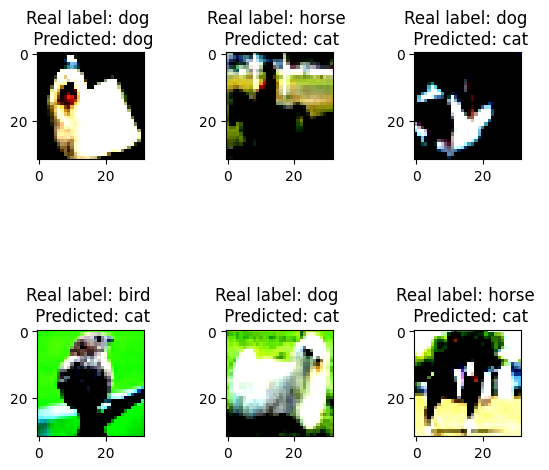

In [ ]:
# Predict some examples
import math

i = 1
no_predictions = 6
col = 3
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=1.6)
for images, label in test_loader:
  for img, lbl in zip(images, label):
    if i == no_predictions + 1:
      break
    plt.subplot(int(math.ceil(no_predictions / col)), col, i)
    output = model((img.view(1,3,32,32).to(device))).to(device)
    plt.title(f"Real label: {classes[lbl.numpy()]} \n Predicted: {classes[torch.max(output.data, 1)[1][0].cpu().numpy()]}")
    plt.imshow(img.permute(1,2,0))
    i += 1
  break